<h1> <strong> <center> Model 2: Logistic Regression </center> </strong>  </h1> 

Our second model preprocesses and classifies a dataset of Urdu-language text articles using both a manual implementation of Logisitic Regression and Scikit-learn's version of the model. The dataset is split and evaluated in the same manner as it was in the implementation of our first model. The results from the manual implementation are compared with those from Scikit-learn to ensure consistency.

<h4> 1) Library Imports </h4>

In [56]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix)

<h4> 2) Data Cleaning and Text Preprocessing </h4>

We have used the Regex and LughaatNLP libraries to clean and preprocess Urdu text. 
This includes:
- removes URLs
- removes punctuation
- removes non-alphanumeric characters
- normalizes the text 
- eliminates stopwords 
- corrects spelling 
- tokenizes the text into words
- joins the tokens back into a processed string

After that we import our clean dataset

In [57]:
df = pd.read_csv("scraped_data.csv")
print(df.shape)
df.head(3)

(2749, 3)


,gold_label,processed_content,processed_title
0,entertainment,مشہور پنجابی گلوکار اداکار بلجیت دوران معلومات...,بھولنا بھی ۳ گانا پرانا بلجیت کارتک دھماکا دار...
1,entertainment,بلا ووڈ دبنگ خان ممبئی ما شاہ رخ خان پرتعیش رہ...,سلمان خان شاہ رخ خان منت متعلق بڑا انکشاف
2,entertainment,بھارتی فلم ٹی وی معروف اداکارہ نیٹ فلکس مشہور ...,نیلم کوشیاری غیر متوقع سوال پرانا حیران حاضرین...


<h4> 3) Data Splitting </h4>

- This part involves extracting the `gold_label` column from the dataframe to form the labels data.
- It also involves using Scikit-Learn's `train_test_split` function to split the data into Training, Validation, and Testing datasets

In [58]:
X = df.drop('gold_label', axis=1)  
y = df['gold_label'] 

train_size = 0.7
validation_size = 0.10
test_size = 0.20

X_train_validation, X_test, y_train_validation, y_test = train_test_split(X, y, test_size= test_size, random_state= 42)
X_train, X_validation, y_train, y_validation = train_test_split(X_train_validation, y_train_validation, test_size= (validation_size / (train_size + validation_size)), random_state= 42)

print(f"Training dataset shape: {X_train.shape}, {y_train.shape}")
print(f"Validation dataset shape: {X_validation.shape}, {y_validation.shape}")
print(f"Test dataset shape: {X_test.shape}, {y_test.shape}")

Training dataset shape: (1924, 2), (1924,)
Validation dataset shape: (275, 2), (275,)
Test dataset shape: (550, 2), (550,)


<h4> 4) Label Encoding and Vectorization </h4>

- Here, we convert the categorical labels into numeric format using a custom class, MyLabelEncoder
- Then, we convert text into numerical features using another custom class, MyCountVectorizer with a vocabulary of the 1,000 most frequent words.

In [59]:
class MyLabelEncoder:
    def __init__(self):
        self.classes_ = None
        self.class_to_index = {}
        self.index_to_class = {}

    def fit(self, labels):
        self.classes_ = sorted(set(labels))
        self.class_to_index = {cls: idx for idx, cls in enumerate(self.classes_)}
        self.index_to_class = {idx: cls for cls, idx in self.class_to_index.items()}
        return self

    def transform(self, labels):
        transformed_labels = []
        for label in labels:
            index = self.class_to_index[label]
            transformed_labels.append(index)
        return transformed_labels

    def inverse_transform(self, indices):
        original_labels = []
        for index in indices:
            label = self.index_to_class[index]
            original_labels.append(label)
        return original_labels

    def fit_transform(self, labels):
        self.fit(labels)
        return self.transform(labels)

label_encoder = MyLabelEncoder()

y_train_encoded = label_encoder.fit_transform(y_train)
y_validation_encoded = label_encoder.transform(y_validation)
y_test_encoded = label_encoder.transform(y_test)


In [60]:
X_train_features = X_train['processed_content'].values
X_validation_features = X_validation['processed_content'].values
X_test_features = X_test['processed_content'].values


class MyCountVectorizer:
    def __init__(self, max_features=None):
        self.max_features = max_features
        self.vocabulary_ = None

    def fit(self, documents):
        word_counts = {}
        for doc in documents:
            words = doc.split() 
            for word in words:
                if word in word_counts:
                    word_counts[word] += 1
                else:
                    word_counts[word] = 1
        
        sorted_word_counts = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)
        most_common_words = sorted_word_counts[:self.max_features]
        self.vocabulary_ = {word: idx for idx, (word, _) in enumerate(most_common_words)}
        return self

    def transform(self, documents):
        vectors = []
        for doc in documents:
            words = doc.split()  
            vector = np.zeros(len(self.vocabulary_), dtype=int)
            for word in words:
                if word in self.vocabulary_:
                    vector[self.vocabulary_[word]] += 1
            vectors.append(vector)
        return np.array(vectors)

    def fit_transform(self, documents):
        self.fit(documents)
        return self.transform(documents)

custom_vectorizer = MyCountVectorizer(max_features=1000)
X_train_vectors = custom_vectorizer.fit_transform(X_train_features)
X_validation_vectors = custom_vectorizer.transform(X_validation_features)
X_test_vectors = custom_vectorizer.transform(X_test_features)

### <h4> 5) Implementation of MultiClass Logistic Regression Class from Scratch </h4>

- **Softmax:** Applies softmax for multi-class probability distribution.
- **Fit:** Trains model using gradient descent with one-hot encoding for labels.
- **Predict:** Outputs class labels based on the highest softmax probability.

In [61]:
class MultiClassLogisticRegression:
    def __init__(self, learning_rate, epochs, num_classes=None):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.num_classes = num_classes
        self.weights = None
        self.bias = None

    @staticmethod
    def softmax(z):
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True)) 
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    def fit(self, X, y):
        n_samples, n_features = X.shape
        if self.num_classes is None:
            self.num_classes = len(np.unique(y))

        self.weights = np.zeros((n_features, self.num_classes))
        self.bias = np.zeros(self.num_classes)

        y_one_hot = np.zeros((n_samples, self.num_classes))
        y_one_hot[np.arange(n_samples), y] = 1

        for i in range(self.epochs):
            linear_model = np.dot(X, self.weights) + self.bias
            predictions = self.softmax(linear_model)

            dw = (1 / n_samples) * np.dot(X.T, (predictions - y_one_hot))
            db = (1 / n_samples) * np.sum(predictions - y_one_hot, axis=0)

            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

    def predict(self, X):
        linear_model = np.dot(X, self.weights) + self.bias
        predictions = self.softmax(linear_model)
        return np.argmax(predictions, axis=1)

<h4> 6) Evaluation Metrics </h4>

Below we have defined a function that will assess the performance using the following evaluation metrics:
- Accuracy
- Class-wise Precision
- Class-wise Recall
- Macro F1 Score
- Confusion Matrix




In [62]:
def make_heat_map(confusion_matrix, title):
  plt.figure(figsize=(12, 6))
  sns.heatmap(confusion_matrix, fmt="d", annot= True, cmap= "Blues", cbar= True)
  plt.title(title)
  plt.xlabel("True Label")
  plt.ylabel("Predicted Label")
  plt.show()
    
def evaluate(y_true, y_pred, target_names):
    accuracy = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {accuracy * 100:.2f}%\n")
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=target_names))
    cm = confusion_matrix(y_true, y_pred)
    make_heat_map(cm, "Confusion Matrix")

<h4> 7) Training the model </h4>

Here we train our model, MultiClassLogisticRegression on the training dataset:

In [63]:
model = MultiClassLogisticRegression(learning_rate=0.01, epochs=10000)
model.fit(X_train_vectors, y_train_encoded)

<h4> 8) Testing on the Validation Dataset </h4>

Here, we test our model on the validation dataset and assess its performance using the evaluate metrics:


Accuracy: 96.73%

Classification Report:
                    precision    recall  f1-score   support

          business       0.98      0.96      0.97        46
     entertainment       0.97      0.97      0.97        61
science-technology       1.00      0.92      0.96        37
            sports       0.98      1.00      0.99        60
             world       0.93      0.97      0.95        71

          accuracy                           0.97       275
         macro avg       0.97      0.96      0.97       275
      weighted avg       0.97      0.97      0.97       275



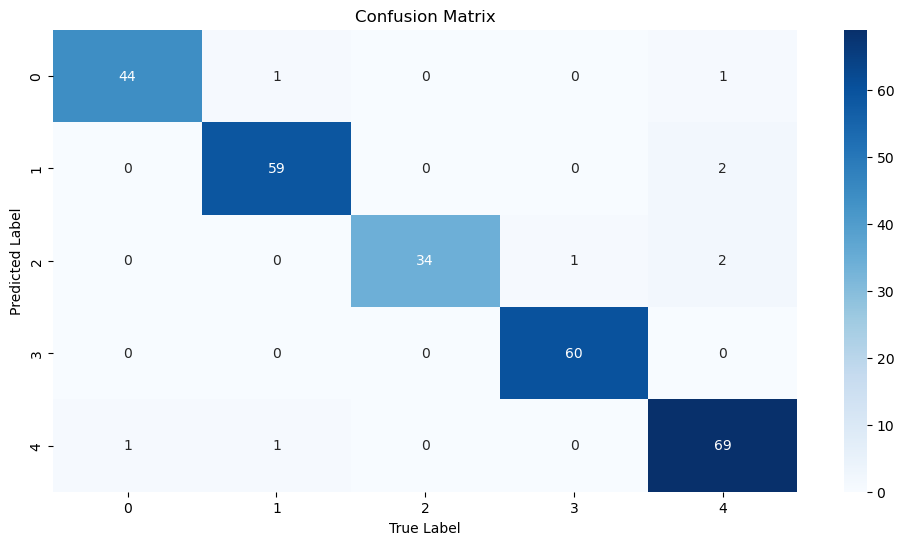

In [64]:
y_predicted_validation = model.predict(X_validation_vectors)
evaluate(y_validation_encoded, y_predicted_validation, label_encoder.classes_)

<h4> 9) Testing on the Test Dataset </h4>

Here, we test our model on the test dataset and assess its performance using the metrics mentioned above.

Accuracy: 95.27%

Classification Report:
                    precision    recall  f1-score   support

          business       0.98      0.97      0.97       117
     entertainment       0.98      0.94      0.96       131
science-technology       0.91      0.95      0.93        64
            sports       0.98      0.98      0.98       121
             world       0.89      0.93      0.91       117

          accuracy                           0.95       550
         macro avg       0.95      0.95      0.95       550
      weighted avg       0.95      0.95      0.95       550



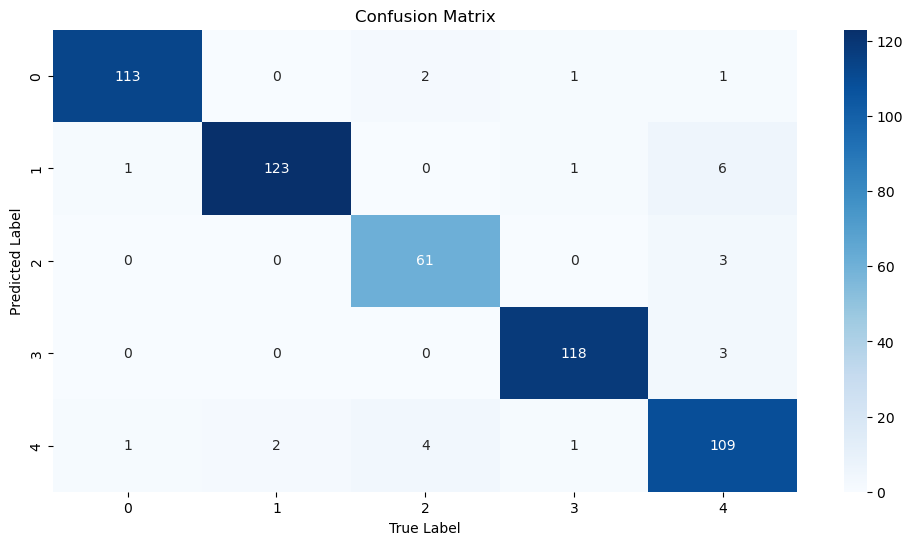

In [65]:
y_predicted_test = model.predict(X_test_vectors)
evaluate(y_test_encoded, y_predicted_test, label_encoder.classes_)

<h4> 10) Implementing the Logistic Regression Machine Learning Model using Scikit-Learn </h4>

Here we simply implement the Naive Bayes model using the Scikit-Learn library to compare the performance of our own model with that of the standard Scikit-Learn one.

In [66]:
from sklearn.linear_model import LogisticRegression

sklearn_log_reg = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, random_state=42)
sklearn_log_reg.fit(X_train_vectors, y_train_encoded)

y_validation_predicted_sklearn_log_reg = sklearn_log_reg.predict(X_validation_vectors)
y_test_predicted_sklearn_log_reg = sklearn_log_reg.predict(X_test_vectors)

sklearn_accuracy_validation_log_reg = accuracy_score(y_validation_encoded, y_validation_predicted_sklearn_log_reg)
sklearn_accuracy_test_log_reg = accuracy_score(y_test_encoded, y_test_predicted_sklearn_log_reg)

manual_accuracy_validation_log_reg = accuracy_score(y_validation_encoded, y_predicted_validation)
manual_accuracy_test_log_reg = accuracy_score(y_test_encoded, y_predicted_test)

print(f"Sklearn Logistic Regression Accuracy for validation data set: {sklearn_accuracy_validation_log_reg * 100:.2f}%")
print(f"Manual Logistic Regression Accuracy for validation data set: {manual_accuracy_validation_log_reg * 100:.2f}% \n")
print(f"Sklearn Logistic Regression Accuracy for test data set: {sklearn_accuracy_test_log_reg * 100:.2f}%")
print(f"Manual Logistic Regression Accuracy for test data set: {manual_accuracy_test_log_reg * 100:.2f}%")

/opt/anaconda3/envs/ML_env/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Sklearn Logistic Regression Accuracy for validation data set: 96.73%
Manual Logistic Regression Accuracy for validation data set: 96.73% 

Sklearn Logistic Regression Accuracy for test data set: 94.55%
Manual Logistic Regression Accuracy for test data set: 95.27%
